**Libraries**

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.impute import SimpleImputer

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✓ Libraries imported successfully!")


✓ Libraries imported successfully!


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Internship/exoplanet.csv', comment='#', low_memory=False)

print(f"📊 Dataset shape: {df.shape}")
print(f"📈 Number of columns: {len(df.columns)}")
print(f"📉 Number of rows: {len(df)}")


📊 Dataset shape: (39212, 289)
📈 Number of columns: 289
📉 Number of rows: 39212


In [4]:
print("\n" + "="*50)
print("DATASET INFORMATION")
print("="*50)
print(df.info())


DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39212 entries, 0 to 39211
Columns: 289 entries, rowid to pl_ndispec
dtypes: float64(254), int64(7), object(28)
memory usage: 86.5+ MB
None


In [5]:
# Display column categories
print("\n" + "="*50)
print("COLUMN CATEGORIES")
print("="*50)
cols_by_type = {
    'Identification': ['pl_name', 'hostname', 'pl_letter', 'tic_id'],
    'Discovery': ['discoverymethod', 'disc_year', 'disc_facility'],
    'Orbital': ['pl_orbper', 'pl_orbsmax', 'pl_orbeccen'],
    'Physical': ['pl_rade', 'pl_radj', 'pl_masse', 'pl_massj', 'pl_bmassj'],
    'Stellar': ['st_teff', 'st_rad', 'st_mass', 'st_met', 'st_spectype'],
    'System': ['sy_dist', 'sy_pnum', 'sy_snum']
}

for category, columns in cols_by_type.items():
    available_cols = [col for col in columns if col in df.columns]
    if available_cols:
        print(f"\n{category}:")
        print(f"  {', '.join(available_cols[:3])}" +
              ("..." if len(available_cols) > 3 else ""))


COLUMN CATEGORIES

Identification:
  pl_name, hostname, pl_letter...

Discovery:
  discoverymethod, disc_year, disc_facility

Orbital:
  pl_orbper, pl_orbsmax, pl_orbeccen

Physical:
  pl_rade, pl_radj, pl_masse...

Stellar:
  st_teff, st_rad, st_mass...

System:
  sy_dist, sy_pnum, sy_snum


In [6]:
# Display sample data
print("\n" + "="*50)
print("SAMPLE DATA (First 3 rows)")
print("="*50)
print(df[['pl_name', 'hostname', 'discoverymethod', 'disc_year', 'pl_orbper', 'pl_radj']].head(3))


SAMPLE DATA (First 3 rows)
    pl_name hostname  discoverymethod  disc_year  pl_orbper  pl_radj
0  11 Com b   11 Com  Radial Velocity       2007     323.21      NaN
1  11 Com b   11 Com  Radial Velocity       2007     326.03      NaN
2  11 Com b   11 Com  Radial Velocity       2007        NaN      NaN


## **Data Preprocessing Pipeline**

In [11]:
class ExoplanetPreprocessor:
    def __init__(self, df):
        self.df = df.copy()
        self.original_shape = df.shape
        self.report = {}

    def clean_column_names(self):
        """Clean and standardize column names"""
        print("🔧 Cleaning column names...")
        self.df.columns = [col.strip().lower().replace(' ', '_') for col in self.df.columns]
        return self

    def handle_missing_values(self, threshold=0.7):
        """Handle missing values with intelligent strategies"""
        print("\n🔍 Analyzing missing values...")

        # Calculate missing percentages
        missing_percent = (self.df.isnull().sum() / len(self.df)) * 100
        missing_df = pd.DataFrame({
            'column': missing_percent.index,
            'missing_percentage': missing_percent.values
        }).sort_values('missing_percentage', ascending=False)

        # Store missing value report
        self.report['missing_values'] = missing_df

        print("📊 Missing Value Statistics:")
        print(f"  • Columns with >80% missing: {len(missing_df[missing_df['missing_percentage'] > 80])}")
        print(f"  • Columns with >50% missing: {len(missing_df[missing_df['missing_percentage'] > 50])}")
        print(f"  • Columns with >30% missing: {len(missing_df[missing_df['missing_percentage'] > 30])}")

        # Drop columns with too many missing values
        columns_to_drop = missing_df[missing_df['missing_percentage'] > threshold * 100]['column'].tolist()
        # Keep essential columns
        essential_cols = ['pl_name', 'hostname', 'default_flag', 'discoverymethod', 'disc_year']
        columns_to_drop = [col for col in columns_to_drop if col not in essential_cols]

        print(f"\n🗑️  Dropping {len(columns_to_drop)} columns with >{threshold*100}% missing values")
        self.df = self.df.drop(columns=columns_to_drop)

        # Impute remaining missing values
        self._impute_missing_values()

        return self

    def _impute_missing_values(self):
        """Impute missing values based on data type"""
        print("\n🔄 Imputing missing values...")

        # Separate numerical and categorical columns
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns
        categorical_cols = self.df.select_dtypes(include=['object']).columns

        # Impute numerical columns with median
        for col in numerical_cols:
            if self.df[col].isnull().any():
                self.df[col] = self.df[col].fillna(self.df[col].median())

        # Impute categorical columns with mode
        for col in categorical_cols:
            if col in self.df.columns and self.df[col].isnull().any():
                self.df[col] = self.df[col].fillna(self.df[col].mode()[0]
                                                  if not self.df[col].mode().empty else 'Unknown')

        return self

    def create_derived_features(self):
        """Create new features from existing data"""
        print("\n🎯 Creating derived features...")

        # 1. Planet classification by mass
        if 'pl_bmassj' in self.df.columns:
            conditions = [
                self.df['pl_bmassj'] < 0.03,
                (self.df['pl_bmassj'] >= 0.03) & (self.df['pl_bmassj'] < 0.1),
                (self.df['pl_bmassj'] >= 0.1) & (self.df['pl_bmassj'] < 0.5),
                (self.df['pl_bmassj'] >= 0.5) & (self.df['pl_bmassj'] < 2),
                (self.df['pl_bmassj'] >= 2) & (self.df['pl_bmassj'] < 13),
                self.df['pl_bmassj'] >= 13
            ]
            choices = ['Super-Earth', 'Neptune-like', 'Sub-Jupiter',
                      'Jupiter-like', 'Super-Jupiter', 'Brown Dwarf']
            self.df['planet_class'] = np.select(conditions, choices, default='Unknown')

        # 2. Habitability indicator
        if all(col in self.df.columns for col in ['pl_insol', 'pl_eqt']):
            self.df['habitability_index'] = (
                (self.df['pl_insol'] > 0.35) &
                (self.df['pl_insol'] < 1.5) &
                (self.df['pl_eqt'] > 250) &
                (self.df['pl_eqt'] < 320)
            ).astype(int)

        # 3. Orbital period categories
        if 'pl_orbper' in self.df.columns:
            bins = [0, 1, 10, 100, 365, 1000, 10000, float('inf')]
            labels = ['<1d', '1-10d', '10-100d', '100-365d', '1-10y', '10-100y', '>100y']
            self.df['orbital_period_category'] = pd.cut(
                self.df['pl_orbper'], bins=bins, labels=labels, right=False
            )

        # 4. Stellar classification
        if 'st_teff' in self.df.columns:
            conditions = [
                self.df['st_teff'] > 7500,
                (self.df['st_teff'] > 6000) & (self.df['st_teff'] <= 7500),
                (self.df['st_teff'] > 5200) & (self.df['st_teff'] <= 6000),
                (self.df['st_teff'] > 3700) & (self.df['st_teff'] <= 5200),
                self.df['st_teff'] <= 3700
            ]
            choices = ['A-type', 'F-type', 'G-type', 'K-type', 'M-type']
            self.df['stellar_class'] = np.select(conditions, choices, default='Unknown')

        # 5. Calculate density if possible
        if all(col in self.df.columns for col in ['pl_bmassj', 'pl_radj']):
            # Jupiter mass = 1.898e27 kg, Jupiter radius = 7.1492e7 m
            mass_kg = self.df['pl_bmassj'] * 1.898e27
            radius_m = self.df['pl_radj'] * 7.1492e7
            volume = (4/3) * np.pi * radius_m**3
            self.df['density_gcm3'] = (mass_kg / volume) / 1000  # Convert to g/cm³

        print(f"✅ Created {self.df.shape[1] - self.original_shape[1]} new features")
        return self

    def handle_outliers(self, method='iqr', threshold=1.5):
        """Handle outliers using specified method"""
        print(f"\n⚡ Handling outliers using {method.upper()} method...")

        numerical_cols = self.df.select_dtypes(include=[np.number]).columns
        key_cols = ['pl_orbper', 'pl_orbsmax', 'pl_radj', 'pl_bmassj',
                   'pl_eqt', 'st_teff', 'st_rad', 'st_mass']
        cols_to_process = [col for col in key_cols if col in numerical_cols]

        outliers_report = {}

        for col in cols_to_process:
            if method == 'iqr':
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR

                outliers = ((self.df[col] < lower_bound) | (self.df[col] > upper_bound)).sum()
                outliers_report[col] = {
                    'outliers': outliers,
                    'percentage': (outliers / len(self.df)) * 100
                }

                # Cap outliers
                self.df[col] = np.where(self.df[col] < lower_bound, lower_bound, self.df[col])
                self.df[col] = np.where(self.df[col] > upper_bound, upper_bound, self.df[col])

        self.report['outliers'] = pd.DataFrame.from_dict(outliers_report, orient='index')
        return self

    def encode_categorical_variables(self):
        """Encode categorical variables for analysis"""
        print("\n🔠 Encoding categorical variables...")

        # One-hot encode important categorical features
        categorical_cols = ['discoverymethod', 'planet_class', 'orbital_period_category']
        categorical_cols = [col for col in categorical_cols if col in self.df.columns]

        for col in categorical_cols:
            dummies = pd.get_dummies(self.df[col], prefix=col, drop_first=True)
            self.df = pd.concat([self.df, dummies], axis=1)

        # Label encode other categorical variables
        self.label_encoders = {}
        label_cols = ['st_spectype', 'stellar_class']
        label_cols = [col for col in label_cols if col in self.df.columns]

        for col in label_cols:
            le = LabelEncoder()
            self.df[f'{col}_encoded'] = le.fit_transform(
                self.df[col].fillna('Unknown').astype(str)
            )
            self.label_encoders[col] = le

        return self

    def normalize_data(self):
        """Normalize numerical data"""
        print("\n📏 Normalizing numerical data...")

        numerical_cols = self.df.select_dtypes(include=[np.number]).columns
        exclude_cols = ['rowid', 'default_flag', 'sy_snum', 'sy_pnum', 'sy_mnum']
        cols_to_normalize = [col for col in numerical_cols
                           if col not in exclude_cols and not col.endswith('_encoded')]

        # Remove columns with infinite values
        cols_to_normalize = [col for col in cols_to_normalize
                           if self.df[col].notna().all() and np.isfinite(self.df[col]).all()]

        if cols_to_normalize:
            self.scaler = StandardScaler()
            normalized_data = self.scaler.fit_transform(self.df[cols_to_normalize])
            normalized_df = pd.DataFrame(
                normalized_data,
                columns=[f'{col}_norm' for col in cols_to_normalize],
                index=self.df.index
            )
            self.df = pd.concat([self.df, normalized_df], axis=1)

        return self

    def get_processed_data(self):
        """Return processed data and reports"""
        print("\n" + "="*50)
        print("PREPROCESSING COMPLETE")
        print("="*50)
        print(f"📊 Original shape: {self.original_shape}")
        print(f"📈 Final shape: {self.df.shape}")
        print(f"🎯 Features added: {self.df.shape[1] - self.original_shape[1]}")
        print(f"📝 Missing values handled: {self.report.get('missing_values', pd.DataFrame()).shape[0]} columns analyzed")

        return self.df, self.report

# Apply preprocessing
print("🚀 STARTING DATA PREPROCESSING")
print("="*50)

preprocessor = ExoplanetPreprocessor(df)
processed_df, reports = (preprocessor
    .clean_column_names()
    .handle_missing_values(threshold=0.7)
    .create_derived_features()
    .handle_outliers(method='iqr', threshold=1.5)
    .encode_categorical_variables()
    .normalize_data()
    .get_processed_data())

# Display processed data info
print("\n📋 Processed Data Info:")
print(processed_df.info(verbose=False))

# Display key statistics
print("\n📊 Key Statistics:")
key_stats_cols = ['pl_orbper', 'pl_orbsmax', 'pl_radj', 'pl_bmassj', 'pl_eqt', 'st_teff']
for col in key_stats_cols:
    if col in processed_df.columns:
        print(f"\n{col}:")
        print(f"  Mean: {processed_df[col].mean():.2f}")
        print(f"  Std: {processed_df[col].std():.2f}")
        print(f"  Min: {processed_df[col].min():.2f}")
        print(f"  Max: {processed_df[col].max():.2f}")


🚀 STARTING DATA PREPROCESSING
🔧 Cleaning column names...

🔍 Analyzing missing values...
📊 Missing Value Statistics:
  • Columns with >80% missing: 107
  • Columns with >50% missing: 132
  • Columns with >30% missing: 166

🗑️  Dropping 112 columns with >70.0% missing values

🔄 Imputing missing values...

🎯 Creating derived features...
✅ Created -109 new features

⚡ Handling outliers using IQR method...

🔠 Encoding categorical variables...

📏 Normalizing numerical data...

PREPROCESSING COMPLETE
📊 Original shape: (39212, 289)
📈 Final shape: (39212, 346)
🎯 Features added: 57
📝 Missing values handled: 289 columns analyzed

📋 Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39212 entries, 0 to 39211
Columns: 346 entries, rowid to habitability_index_norm
dtypes: bool(16), category(1), float64(295), int64(9), object(25)
memory usage: 99.1+ MB
None

📊 Key Statistics:

pl_orbper:
  Mean: 17.39
  Std: 16.94
  Min: 0.09
  Max: 52.00

pl_orbsmax:
  Mean: 0.10
  Std: 0.03
  Mi

**Data Visualization**

In [15]:
print("🎨 CREATING DATA VISUALIZATIONS")
print("="*50)

# Set up visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12


🎨 CREATING DATA VISUALIZATIONS


**4.1 Distribution Plots**

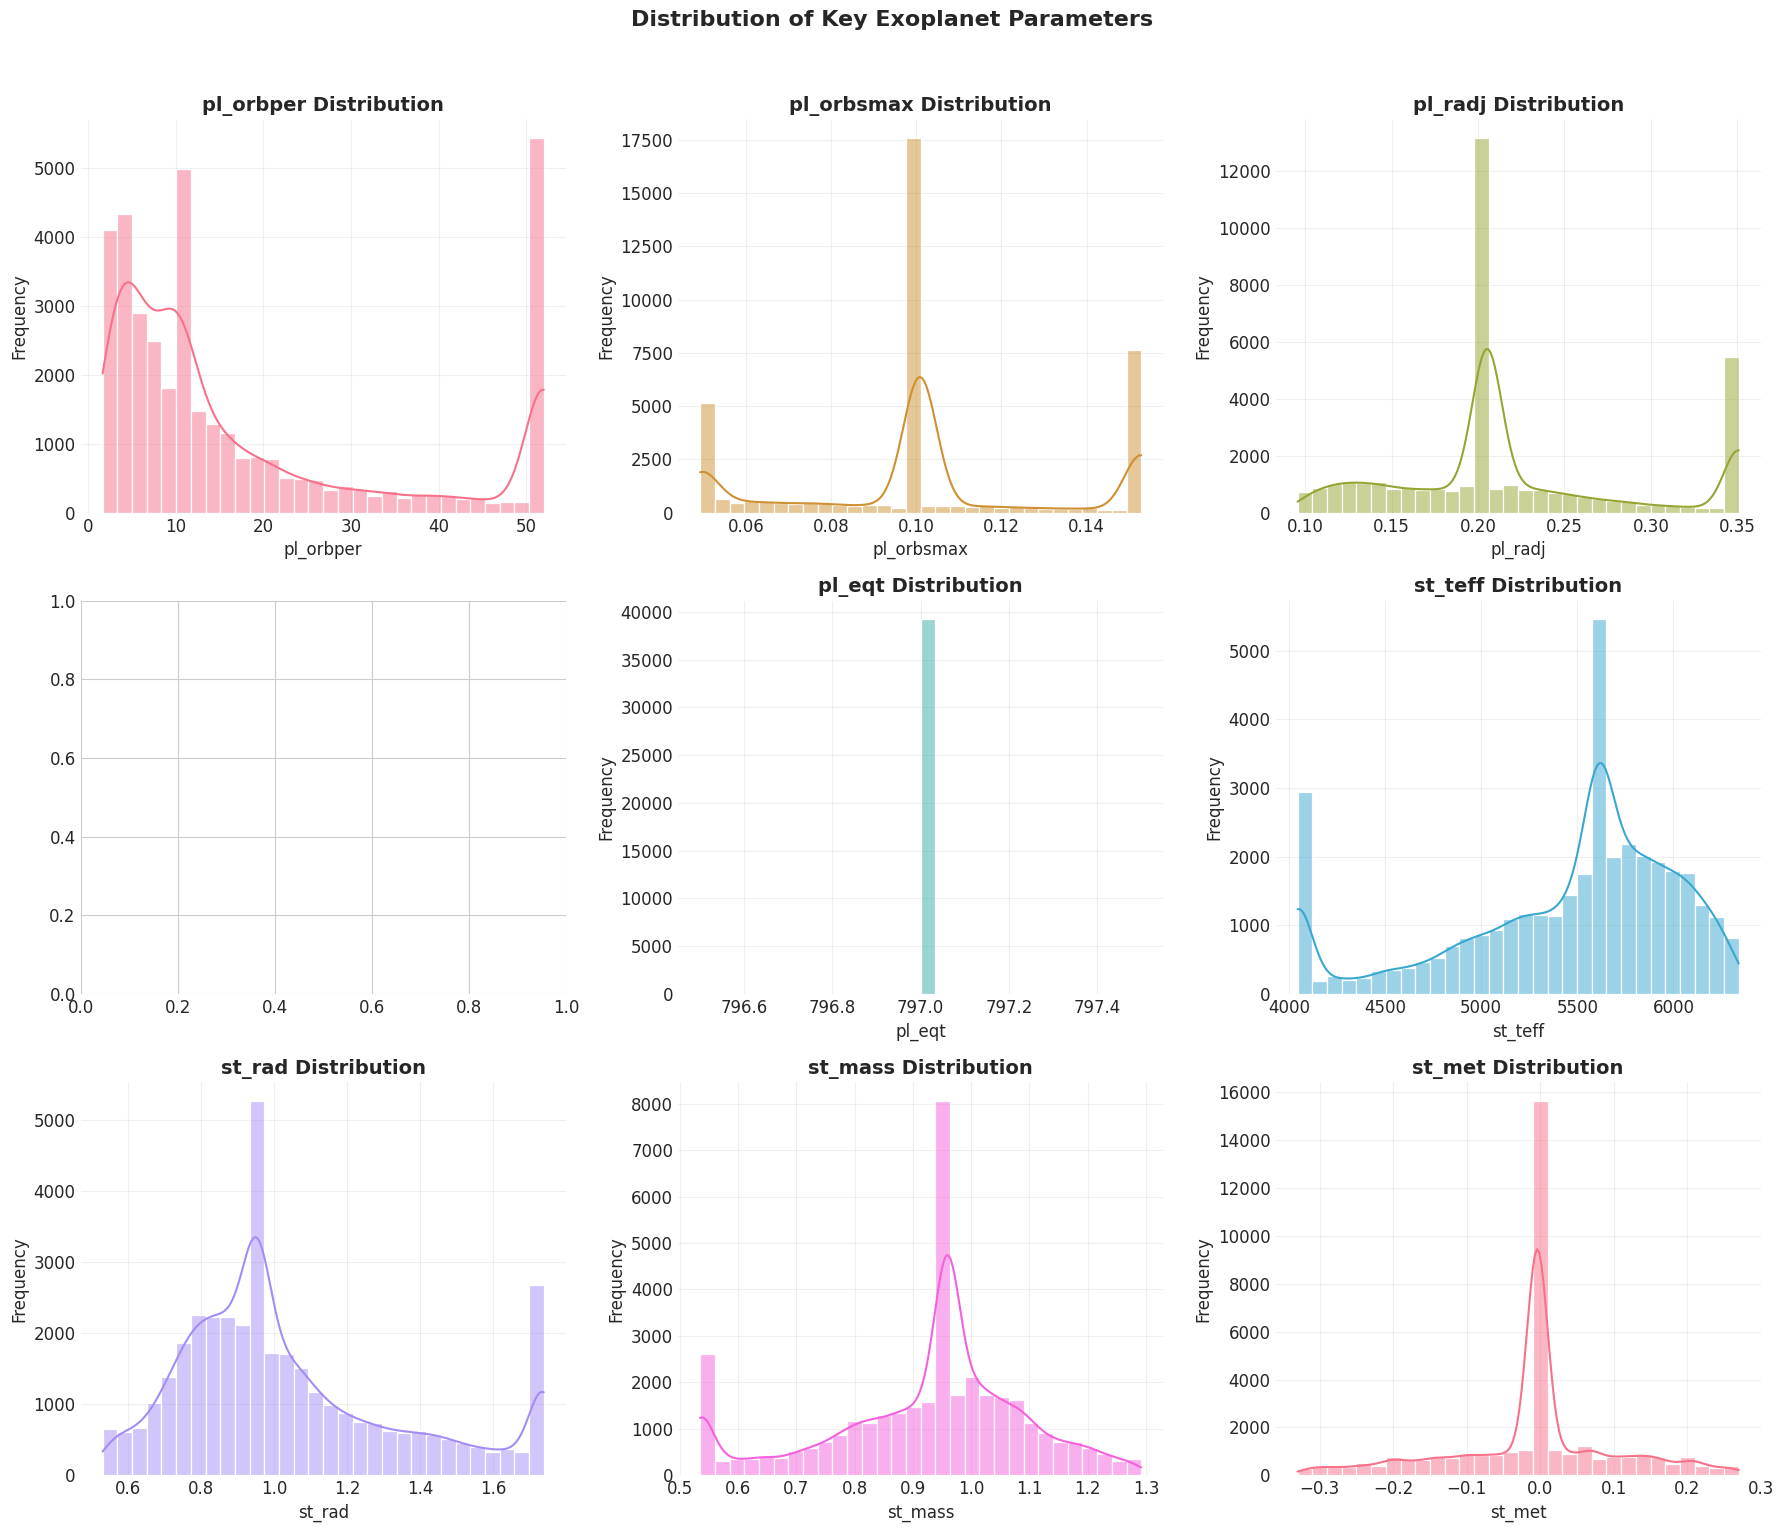

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

key_variables = ['pl_orbper', 'pl_orbsmax', 'pl_radj', 'pl_bmassj',
                'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'st_met']

for i, var in enumerate(key_variables):
    if i < len(axes) and var in processed_df.columns:
        ax = axes[i]

        # Remove extreme outliers for better visualization
        data = processed_df[var].dropna()
        if len(data) > 0:
            Q1 = data.quantile(0.05)
            Q3 = data.quantile(0.95)
            filtered_data = data[(data >= Q1) & (data <= Q3)]

            # Plot histogram with KDE
            sns.histplot(filtered_data, bins=30, kde=True, ax=ax,
                        color=sns.color_palette('husl', n_colors=8)[i % 8])

            ax.set_title(f'{var} Distribution', fontsize=14, fontweight='bold')
            ax.set_xlabel(var)
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)

plt.suptitle('Distribution of Key Exoplanet Parameters',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Correlation Heatmap**

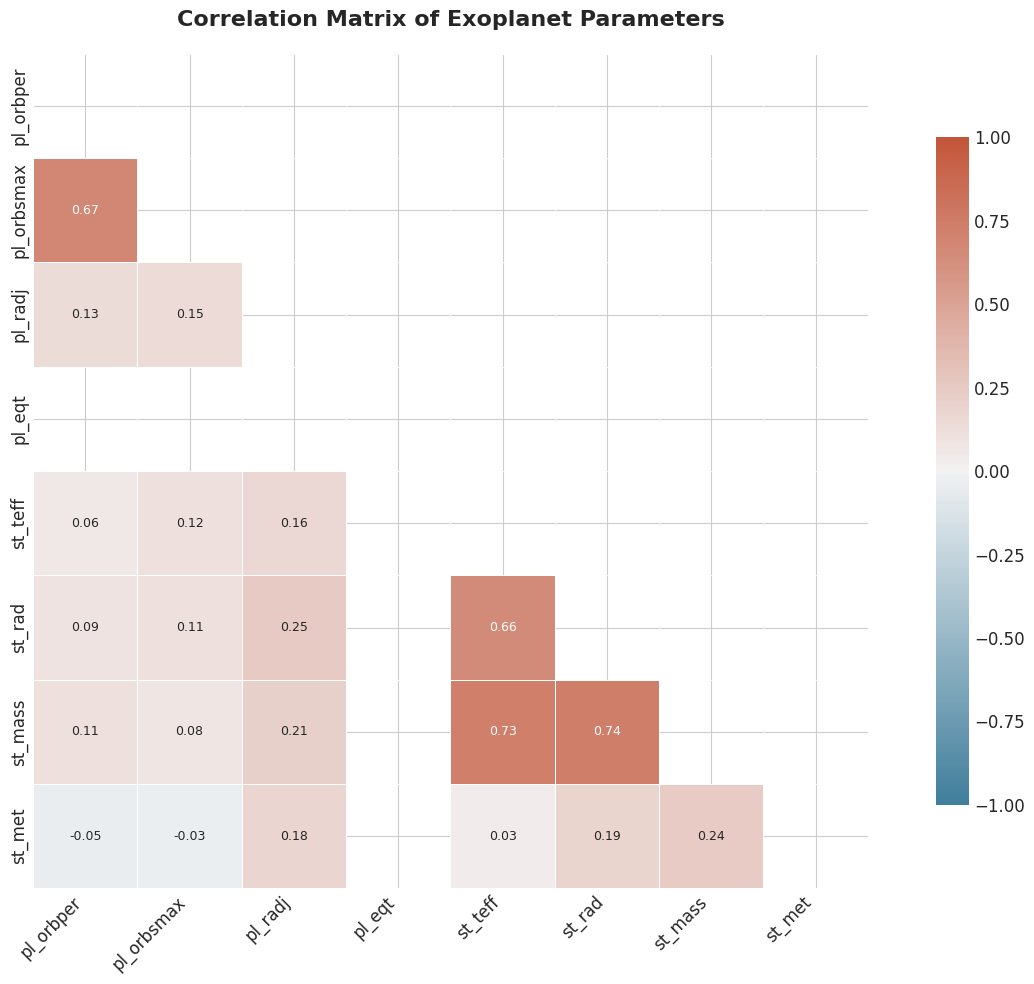

In [18]:
correlation_vars = ['pl_orbper', 'pl_orbsmax', 'pl_radj', 'pl_bmassj',
                   'pl_eqt', 'st_teff', 'st_rad', 'st_mass', 'st_met',
                   'density_gcm3']
correlation_vars = [v for v in correlation_vars if v in processed_df.columns]

if correlation_vars:
    corr_matrix = processed_df[correlation_vars].corr()

    plt.figure(figsize=(14, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .8},
                annot=True, fmt='.2f', annot_kws={'size': 9})

    plt.title('Correlation Matrix of Exoplanet Parameters',
             fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



**Discovery Analysis**

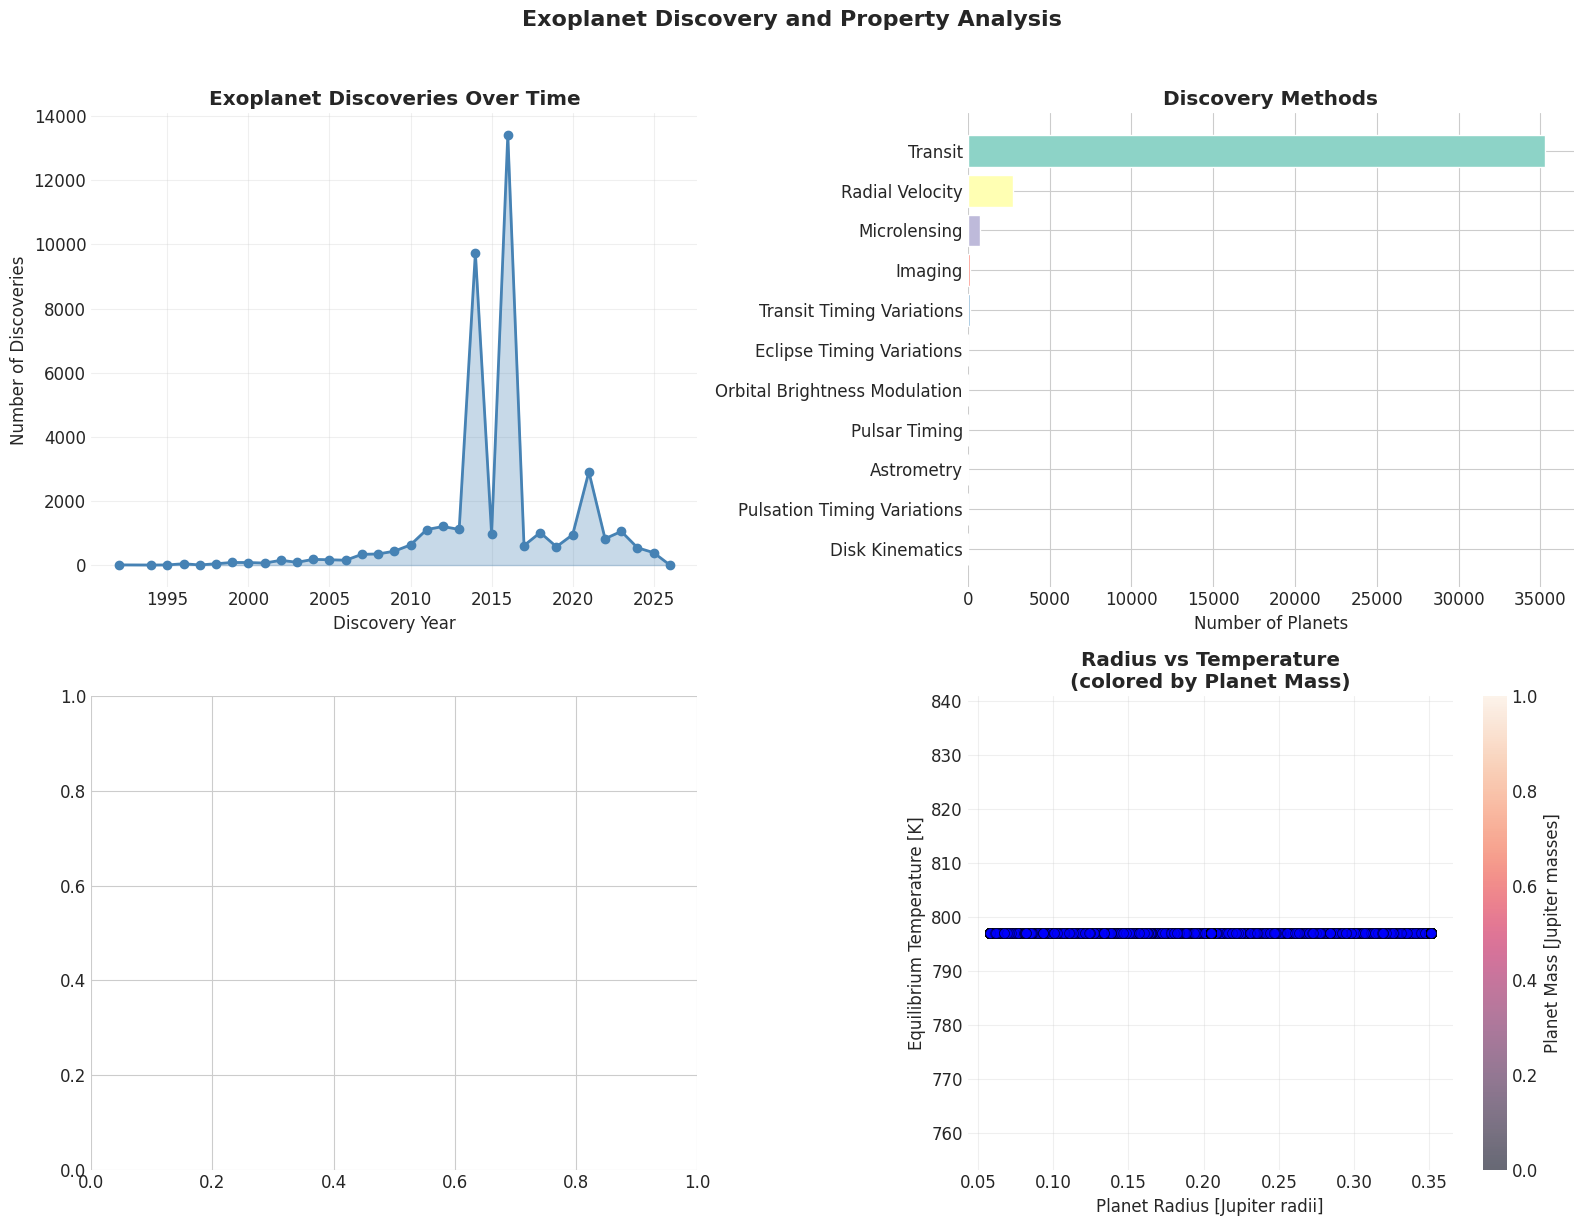

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Discoveries over time
if 'disc_year' in processed_df.columns:
    discoveries_per_year = processed_df['disc_year'].value_counts().sort_index()
    axes[0,0].plot(discoveries_per_year.index, discoveries_per_year.values,
                  marker='o', linewidth=2, markersize=6, color='steelblue')
    axes[0,0].fill_between(discoveries_per_year.index, 0, discoveries_per_year.values,
                          alpha=0.3, color='steelblue')
    axes[0,0].set_xlabel('Discovery Year')
    axes[0,0].set_ylabel('Number of Discoveries')
    axes[0,0].set_title('Exoplanet Discoveries Over Time', fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)

# Plot 2: Discovery methods
if 'discoverymethod' in processed_df.columns:
    method_counts = processed_df['discoverymethod'].value_counts()
    colors = plt.cm.Set3(np.linspace(0, 1, len(method_counts)))
    axes[0,1].barh(range(len(method_counts)), method_counts.values, color=colors)
    axes[0,1].set_yticks(range(len(method_counts)))
    axes[0,1].set_yticklabels(method_counts.index)
    axes[0,1].set_xlabel('Number of Planets')
    axes[0,1].set_title('Discovery Methods', fontweight='bold')
    axes[0,1].invert_yaxis()

# Plot 3: Mass vs Orbital Period
if all(col in processed_df.columns for col in ['pl_orbper', 'pl_bmassj']):
    color_data_scatter3 = processed_df['st_teff'] if 'st_teff' in processed_df.columns else 'gray'
    scatter = axes[1,0].scatter(np.log10(processed_df['pl_orbper'] + 1),
                               np.log10(processed_df['pl_bmassj'] + 1e-6),
                               c=color_data_scatter3,
                               cmap='viridis', alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
    axes[1,0].set_xlabel('log10(Orbital Period [days])')
    axes[1,0].set_ylabel('log10(Planet Mass [Jupiter masses])')
    axes[1,0].set_title('Mass vs Orbital Period\n(colored by Stellar Temperature)',
                       fontweight='bold')
    plt.colorbar(scatter, ax=axes[1,0], label='Stellar Temperature [K]')
    axes[1,0].grid(True, alpha=0.3)

# Plot 4: Radius vs Temperature
if all(col in processed_df.columns for col in ['pl_radj', 'pl_eqt']):
    color_data_scatter4 = processed_df['pl_bmassj'] if 'pl_bmassj' in processed_df.columns else 'blue'
    scatter = axes[1,1].scatter(processed_df['pl_radj'], processed_df['pl_eqt'],
                               c=color_data_scatter4,
                               cmap='plasma', alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
    axes[1,1].set_xlabel('Planet Radius [Jupiter radii]')
    axes[1,1].set_ylabel('Equilibrium Temperature [K]')
    axes[1,1].set_title('Radius vs Temperature\n(colored by Planet Mass)',
                       fontweight='bold')
    plt.colorbar(scatter, ax=axes[1,1], label='Planet Mass [Jupiter masses]')
    axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Exoplanet Discovery and Property Analysis',
            fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Advanced Visualizations**

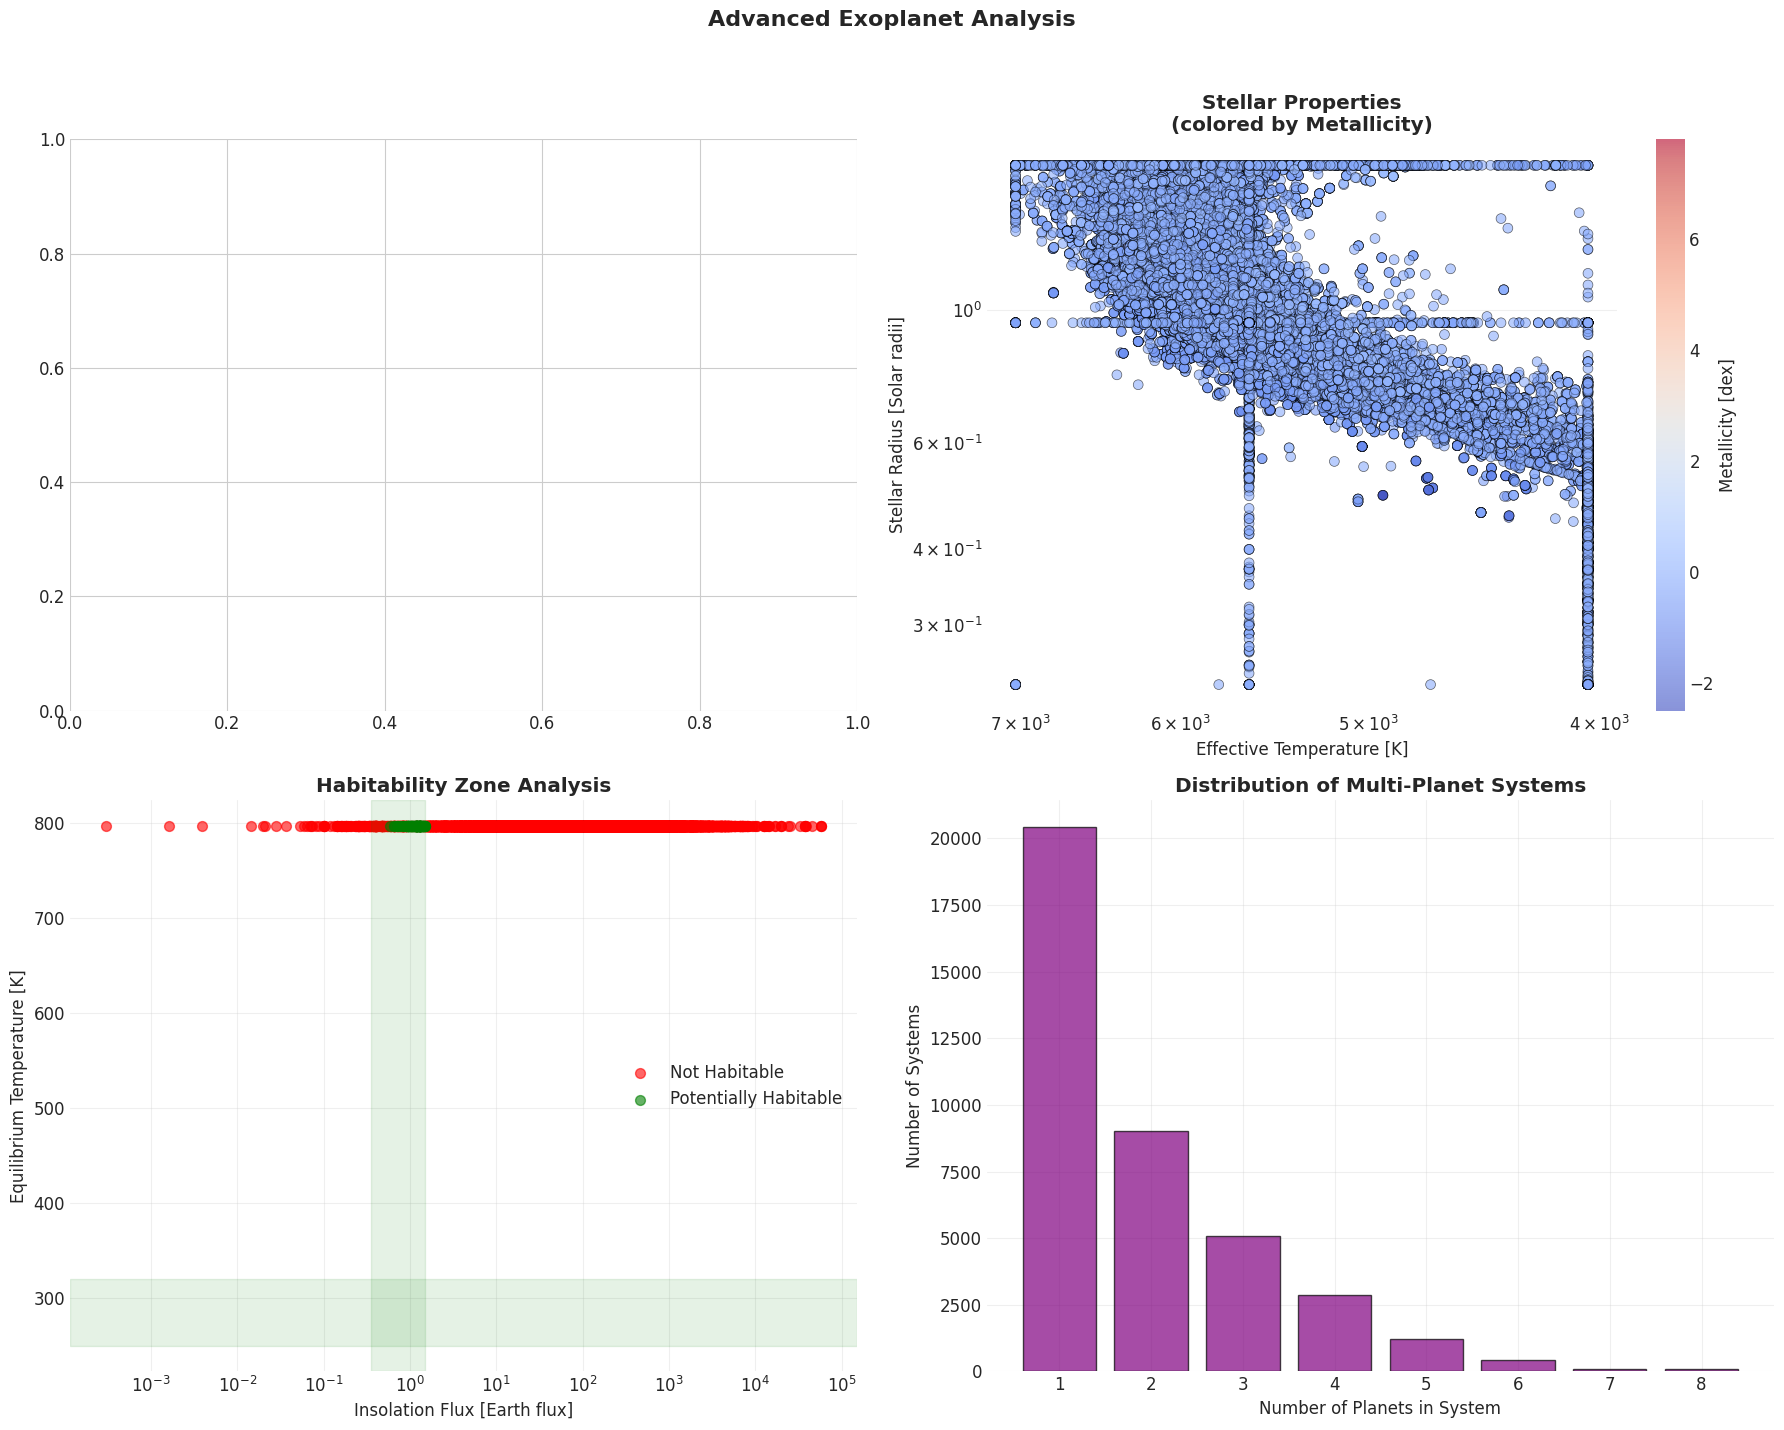

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Planetary System Characteristics
if all(col in processed_df.columns for col in ['pl_bmassj', 'pl_radj', 'planet_class']):
    unique_classes = processed_df['planet_class'].unique()
    colors = plt.cm.tab20c(np.linspace(0, 1, len(unique_classes)))
    color_map = dict(zip(unique_classes, colors))

    for planet_class in unique_classes:
        mask = processed_df['planet_class'] == planet_class
        axes[0,0].scatter(processed_df.loc[mask, 'pl_radj'],
                         processed_df.loc[mask, 'pl_bmassj'],
                         color=color_map[planet_class],
                         label=planet_class, alpha=0.6, s=50)

    axes[0,0].set_xlabel('Planet Radius [Jupiter radii]')
    axes[0,0].set_ylabel('Planet Mass [Jupiter masses]')
    axes[0,0].set_title('Planet Mass vs Radius by Classification', fontweight='bold')
    axes[0,0].legend(loc='upper left', fontsize=9)
    axes[0,0].set_xscale('log')
    axes[0,0].set_yscale('log')
    axes[0,0].grid(True, alpha=0.3)

# Plot 2: Stellar Properties
if all(col in processed_df.columns for col in ['st_teff', 'st_rad', 'stellar_class']):
    scatter = axes[0,1].scatter(processed_df['st_teff'], processed_df['st_rad'],
                               c=processed_df.get('st_met', 0),
                               cmap='coolwarm', alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
    axes[0,1].set_xlabel('Effective Temperature [K]')
    axes[0,1].set_ylabel('Stellar Radius [Solar radii]')
    axes[0,1].set_title('Stellar Properties\n(colored by Metallicity)', fontweight='bold')
    axes[0,1].set_xscale('log')
    axes[0,1].set_yscale('log')
    axes[0,1].invert_xaxis()
    plt.colorbar(scatter, ax=axes[0,1], label='Metallicity [dex]')
    axes[0,1].grid(True, alpha=0.3)

# Plot 3: Habitability Analysis
if all(col in processed_df.columns for col in ['pl_insol', 'pl_eqt', 'habitability_index']):
    colors = ['red', 'green']
    labels = ['Not Habitable', 'Potentially Habitable']

    for idx, color in enumerate(colors):
        mask = processed_df['habitability_index'] == idx
        axes[1,0].scatter(processed_df.loc[mask, 'pl_insol'],
                         processed_df.loc[mask, 'pl_eqt'],
                         color=color, label=labels[idx], alpha=0.6, s=50)

    axes[1,0].axvspan(0.35, 1.5, alpha=0.1, color='green')
    axes[1,0].axhspan(250, 320, alpha=0.1, color='green')
    axes[1,0].set_xlabel('Insolation Flux [Earth flux]')
    axes[1,0].set_ylabel('Equilibrium Temperature [K]')
    axes[1,0].set_title('Habitability Zone Analysis', fontweight='bold')
    axes[1,0].legend()
    axes[1,0].set_xscale('log')
    axes[1,0].grid(True, alpha=0.3)

# Plot 4: Multi-planet Systems
if 'sy_pnum' in processed_df.columns:
    system_counts = processed_df['sy_pnum'].value_counts().sort_index()
    axes[1,1].bar(system_counts.index, system_counts.values,
                 color='purple', alpha=0.7, edgecolor='black')
    axes[1,1].set_xlabel('Number of Planets in System')
    axes[1,1].set_ylabel('Number of Systems')
    axes[1,1].set_title('Distribution of Multi-Planet Systems', fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Advanced Exoplanet Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**3D Visualization (Projection)**

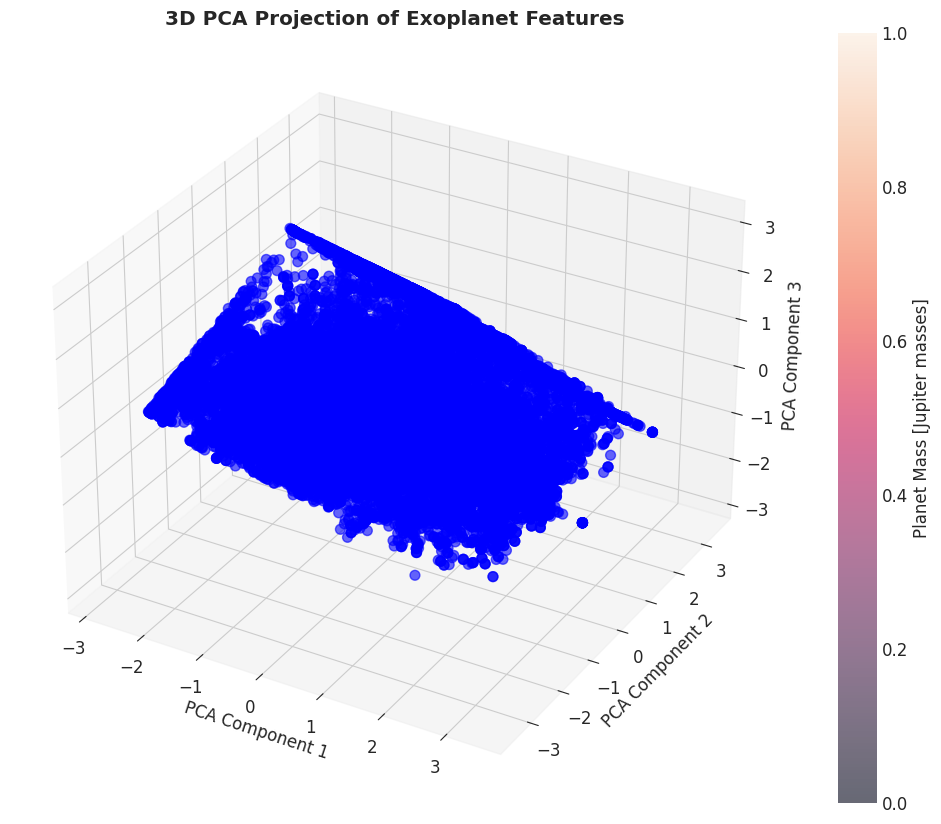

📊 PCA Explained Variance:
  Component 1: 44.12%
  Component 2: 26.88%
  Component 3: 20.91%
  Total: 91.91%


In [22]:
from sklearn.decomposition import PCA

# Select numerical features for PCA
numerical_features = ['pl_orbper_norm', 'pl_orbsmax_norm', 'pl_radj_norm',
                     'pl_bmassj_norm', 'pl_eqt_norm', 'st_teff_norm']
numerical_features = [f for f in numerical_features if f in processed_df.columns]

if len(numerical_features) >= 3:
    pca_data = processed_df[numerical_features].dropna()

    if len(pca_data) > 0:
        pca = PCA(n_components=3)
        pca_result = pca.fit_transform(pca_data)

        fig = plt.figure(figsize=(15, 10))

        # Create 3D scatter plot
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                           c=processed_df.loc[pca_data.index, 'pl_bmassj'] if 'pl_bmassj' in processed_df.columns else 'blue',
                           cmap='viridis', alpha=0.6, s=50)

        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        ax.set_zlabel('PCA Component 3')
        ax.set_title('3D PCA Projection of Exoplanet Features', fontweight='bold')

        plt.colorbar(scatter, ax=ax, label='Planet Mass [Jupiter masses]')
        plt.show()

        # Print explained variance
        print(f"📊 PCA Explained Variance:")
        print(f"  Component 1: {pca.explained_variance_ratio_[0]:.2%}")
        print(f"  Component 2: {pca.explained_variance_ratio_[1]:.2%}")
        print(f"  Component 3: {pca.explained_variance_ratio_[2]:.2%}")
        print(f"  Total: {sum(pca.explained_variance_ratio_):.2%}")

**Anomaly Detection**

🔍 STARTING ANOMALY DETECTION

📊 Preparing features for anomaly detection...
  Selected 7 features: pl_orbper, pl_orbsmax, pl_radj, pl_eqt, st_teff, st_rad, st_mass
  Data shape: (39212, 7)

🌲 Running Isolation Forest (contamination=0.1)...
  Detected 3922 anomalies (10.0%)

🎯 Running Local Outlier Factor (contamination=0.1)...
  Detected 3922 anomalies (10.0%)

🌀 Running DBSCAN (eps=0.5, min_samples=5)...
  Detected 1291 anomalies (3.3%)
  Found 86 clusters

📦 Running Elliptic Envelope (contamination=0.1)...
  Detected 3922 anomalies (10.0%)

🎨 Visualizing anomalies...


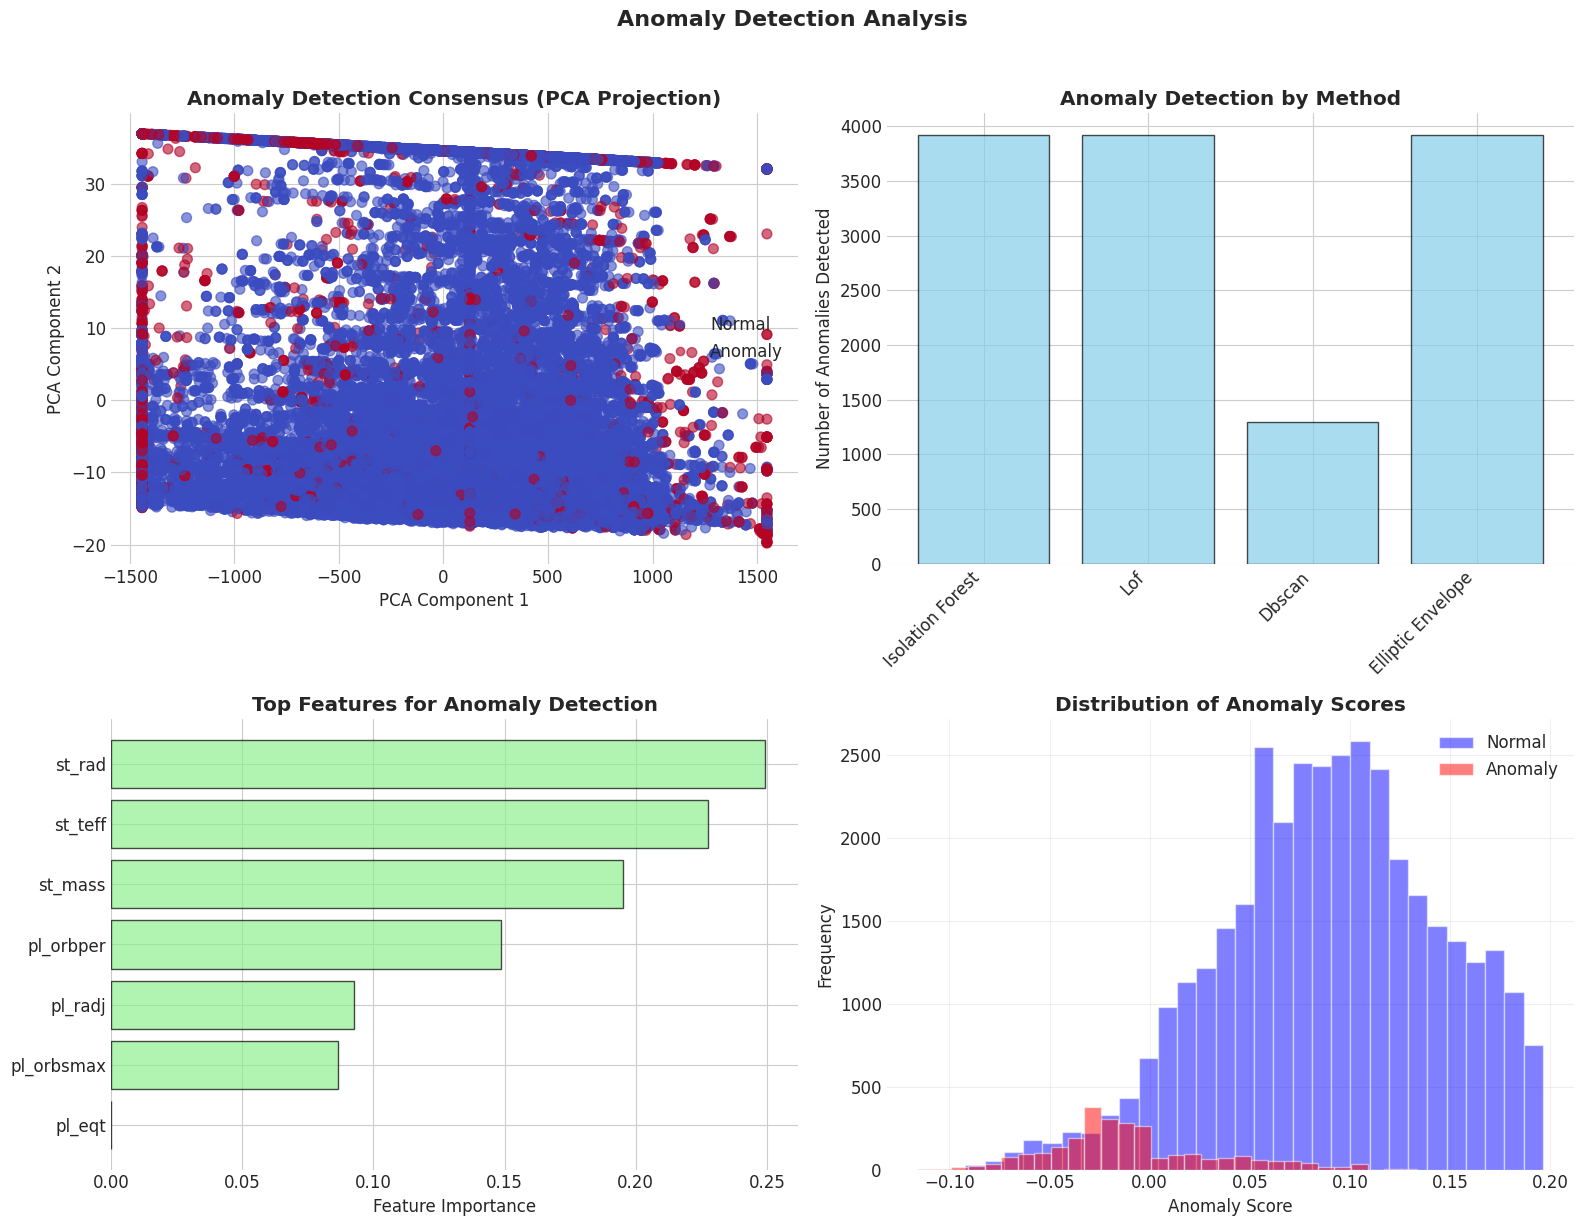


📊 Anomaly Detection Statistics:
  Total points analyzed: 39212
  Consensus anomalies: 2612 (6.7%)

🔍 Top 5 Anomalies Detected:

  Planet: 11 Com b
    pl_radj: 0.21
    pl_orbper: 52.00
    pl_eqt: 797.00

  Planet: 11 Com b
    pl_radj: 0.21
    pl_orbper: 52.00
    pl_eqt: 797.00

  Planet: 11 UMi b
    pl_radj: 0.21
    pl_orbper: 52.00
    pl_eqt: 797.00

  Planet: 11 UMi b
    pl_radj: 0.21
    pl_orbper: 52.00
    pl_eqt: 797.00

  Planet: 14 And b
    pl_radj: 0.21
    pl_orbper: 52.00
    pl_eqt: 797.00


In [24]:
print("🔍 STARTING ANOMALY DETECTION")
print("="*50)

class AnomalyDetector:
    def __init__(self, df):
        self.df = df.copy()
        self.results = {}

    def prepare_features(self):
        """Prepare features for anomaly detection"""
        print("📊 Preparing features for anomaly detection...")

        # Select numerical features
        numerical_features = self.df.select_dtypes(include=[np.number]).columns
        # Remove ID columns and normalized columns
        exclude_patterns = ['_norm', '_encoded', 'flag', 'rowid', 'index']
        features = [col for col in numerical_features
                   if not any(pattern in col for pattern in exclude_patterns)]

        # Select key features
        key_features = ['pl_orbper', 'pl_orbsmax', 'pl_radj', 'pl_bmassj',
                       'pl_eqt', 'st_teff', 'st_rad', 'st_mass']
        features = [f for f in key_features if f in features]

        self.feature_data = self.df[features].dropna()
        print(f"  Selected {len(features)} features: {', '.join(features)}")
        print(f"  Data shape: {self.feature_data.shape}")

        return self

    def detect_with_isolation_forest(self, contamination=0.1):
        """Detect anomalies using Isolation Forest"""
        print(f"\n🌲 Running Isolation Forest (contamination={contamination})...")

        iso_forest = IsolationForest(
            n_estimators=100,
            max_samples='auto',
            contamination=contamination,
            random_state=42,
            n_jobs=-1
        )

        predictions = iso_forest.fit_predict(self.feature_data)
        scores = iso_forest.decision_function(self.feature_data)

        self.results['isolation_forest'] = {
            'predictions': predictions,
            'scores': scores,
            'anomalies': predictions == -1
        }

        anomalies = predictions == -1
        print(f"  Detected {anomalies.sum()} anomalies ({anomalies.sum()/len(predictions):.1%})")

        return self

    def detect_with_local_outlier_factor(self, contamination=0.1):
        """Detect anomalies using Local Outlier Factor"""
        print(f"\n🎯 Running Local Outlier Factor (contamination={contamination})...")

        lof = LocalOutlierFactor(
            n_neighbors=20,
            contamination=contamination,
            novelty=False,
            n_jobs=-1
        )

        predictions = lof.fit_predict(self.feature_data)
        scores = lof.negative_outlier_factor_

        self.results['lof'] = {
            'predictions': predictions,
            'scores': scores,
            'anomalies': predictions == -1
        }

        anomalies = predictions == -1
        print(f"  Detected {anomalies.sum()} anomalies ({anomalies.sum()/len(predictions):.1%})")

        return self

    def detect_with_dbscan(self, eps=0.5, min_samples=5):
        """Detect anomalies using DBSCAN"""
        print(f"\n🌀 Running DBSCAN (eps={eps}, min_samples={min_samples})...")

        # Standardize data for DBSCAN
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.feature_data)

        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        clusters = dbscan.fit_predict(scaled_data)

        # Anomalies are points labeled as -1
        anomalies = clusters == -1

        self.results['dbscan'] = {
            'predictions': clusters,
            'anomalies': anomalies,
            'n_clusters': len(set(clusters)) - (1 if -1 in clusters else 0)
        }

        print(f"  Detected {anomalies.sum()} anomalies ({anomalies.sum()/len(clusters):.1%})")
        print(f"  Found {self.results['dbscan']['n_clusters']} clusters")

        return self

    def detect_with_elliptic_envelope(self, contamination=0.1):
        """Detect anomalies using Elliptic Envelope"""
        print(f"\n📦 Running Elliptic Envelope (contamination={contamination})...")

        envelope = EllipticEnvelope(
            contamination=contamination,
            random_state=42
        )

        predictions = envelope.fit_predict(self.feature_data)
        scores = envelope.decision_function(self.feature_data)

        self.results['elliptic_envelope'] = {
            'predictions': predictions,
            'scores': scores,
            'anomalies': predictions == -1
        }

        anomalies = predictions == -1
        print(f"  Detected {anomalies.sum()} anomalies ({anomalies.sum()/len(predictions):.1%})")

        return self

    def visualize_anomalies(self):
        """Visualize detected anomalies"""
        print("\n🎨 Visualizing anomalies...")

        # Combine results from different methods
        methods = ['isolation_forest', 'lof', 'dbscan', 'elliptic_envelope']
        available_methods = [m for m in methods if m in self.results]

        if not available_methods:
            print("  No anomaly detection results available")
            return self

        # Create a consensus anomaly detection
        anomaly_matrix = np.zeros((len(self.feature_data), len(available_methods)))

        for i, method in enumerate(available_methods):
            anomaly_matrix[:, i] = self.results[method]['anomalies'].astype(int)

        # Consensus: point is anomaly if detected by at least half the methods
        consensus_anomalies = (anomaly_matrix.sum(axis=1) >= len(available_methods) / 2)

        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        # Plot 1: PCA visualization of anomalies
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.feature_data)

        scatter1 = axes[0].scatter(pca_result[:, 0], pca_result[:, 1],
                                 c=consensus_anomalies,
                                 cmap='coolwarm', alpha=0.6, s=50)
        axes[0].set_xlabel('PCA Component 1')
        axes[0].set_ylabel('PCA Component 2')
        axes[0].set_title('Anomaly Detection Consensus (PCA Projection)', fontweight='bold')
        axes[0].legend(handles=scatter1.legend_elements()[0],
                      labels=['Normal', 'Anomaly'])

        # Plot 2: Method comparison
        anomaly_counts = {}
        for method in available_methods:
            anomaly_counts[method] = self.results[method]['anomalies'].sum()

        axes[1].bar(range(len(anomaly_counts)), list(anomaly_counts.values()),
                   color='skyblue', alpha=0.7, edgecolor='black')
        axes[1].set_xticks(range(len(anomaly_counts)))
        axes[1].set_xticklabels([m.replace('_', ' ').title() for m in anomaly_counts.keys()],
                               rotation=45, ha='right')
        axes[1].set_ylabel('Number of Anomalies Detected')
        axes[1].set_title('Anomaly Detection by Method', fontweight='bold')

        # Plot 3: Feature importance for anomalies
        if 'isolation_forest' in self.results:
            # Get feature importances from Isolation Forest
            from sklearn.ensemble import RandomForestClassifier

            # Train a classifier to understand what features differentiate anomalies
            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            clf.fit(self.feature_data, consensus_anomalies)

            importances = clf.feature_importances_
            feature_names = self.feature_data.columns

            # Sort features by importance
            idx = np.argsort(importances)[::-1][:10]  # Top 10 features
            axes[2].barh(range(len(idx)), importances[idx],
                        color='lightgreen', alpha=0.7, edgecolor='black')
            axes[2].set_yticks(range(len(idx)))
            axes[2].set_yticklabels([feature_names[i] for i in idx])
            axes[2].set_xlabel('Feature Importance')
            axes[2].set_title('Top Features for Anomaly Detection', fontweight='bold')
            axes[2].invert_yaxis()

        # Plot 4: Anomaly scores distribution
        if 'isolation_forest' in self.results:
            normal_scores = self.results['isolation_forest']['scores'][~consensus_anomalies]
            anomaly_scores = self.results['isolation_forest']['scores'][consensus_anomalies]

            axes[3].hist(normal_scores, bins=30, alpha=0.5, label='Normal', color='blue')
            axes[3].hist(anomaly_scores, bins=30, alpha=0.5, label='Anomaly', color='red')
            axes[3].set_xlabel('Anomaly Score')
            axes[3].set_ylabel('Frequency')
            axes[3].set_title('Distribution of Anomaly Scores', fontweight='bold')
            axes[3].legend()
            axes[3].grid(True, alpha=0.3)

        plt.suptitle('Anomaly Detection Analysis', fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

        # Print anomaly statistics
        print("\n📊 Anomaly Detection Statistics:")
        print(f"  Total points analyzed: {len(self.feature_data)}")
        print(f"  Consensus anomalies: {consensus_anomalies.sum()} ({consensus_anomalies.sum()/len(self.feature_data):.1%})")

        # Display some anomaly examples
        if consensus_anomalies.any():
            anomaly_indices = np.where(consensus_anomalies)[0]
            anomaly_data = self.feature_data.iloc[anomaly_indices[:5]]  # First 5 anomalies

            print("\n🔍 Top 5 Anomalies Detected:")
            for idx, row in anomaly_data.iterrows():
                original_idx = self.feature_data.index[idx]
                if 'pl_name' in self.df.columns:
                    planet_name = self.df.loc[original_idx, 'pl_name'] if original_idx in self.df.index else 'Unknown'
                else:
                    planet_name = 'Unknown'

                print(f"\n  Planet: {planet_name}")
                for feature in ['pl_bmassj', 'pl_radj', 'pl_orbper', 'pl_eqt']:
                    if feature in row.index:
                        print(f"    {feature}: {row[feature]:.2f}")

        return self

    def get_results(self):
        """Return anomaly detection results"""
        return self.results

# Run anomaly detection
print("\n" + "="*50)
detector = AnomalyDetector(processed_df)
results = (detector
    .prepare_features()
    .detect_with_isolation_forest(contamination=0.1)
    .detect_with_local_outlier_factor(contamination=0.1)
    .detect_with_dbscan(eps=0.5, min_samples=5)
    .detect_with_elliptic_envelope(contamination=0.1)
    .visualize_anomalies()
    .get_results())


**Final Summary and Export**

In [25]:
print("📋 FINAL SUMMARY AND EXPORT")
print("="*50)

# Create summary statistics
summary_stats = {}

# Basic statistics
summary_stats['dataset'] = {
    'original_rows': df.shape[0],
    'original_columns': df.shape[1],
    'processed_rows': processed_df.shape[0],
    'processed_columns': processed_df.shape[1],
    'features_added': processed_df.shape[1] - df.shape[1]
}

# Discovery statistics
if 'discoverymethod' in processed_df.columns:
    summary_stats['discovery'] = {
        'methods': processed_df['discoverymethod'].nunique(),
        'most_common_method': processed_df['discoverymethod'].mode()[0],
        'unique_planets': processed_df['pl_name'].nunique() if 'pl_name' in processed_df.columns else 'N/A'
    }

# Planetary statistics
planetary_stats = {}
for col in ['pl_bmassj', 'pl_radj', 'pl_orbper', 'pl_eqt']:
    if col in processed_df.columns:
        planetary_stats[col] = {
            'mean': processed_df[col].mean(),
            'median': processed_df[col].median(),
            'std': processed_df[col].std(),
            'min': processed_df[col].min(),
            'max': processed_df[col].max()
        }

summary_stats['planetary'] = planetary_stats

# Anomaly statistics
if results:
    anomaly_counts = {}
    for method, result in results.items():
        if 'anomalies' in result:
            anomaly_counts[method] = result['anomalies'].sum()
    summary_stats['anomalies'] = anomaly_counts

# Print summary
print("\n📊 FINAL DATASET SUMMARY:")
print("-" * 40)
print(f"📈 Dataset Size: {processed_df.shape[0]} rows × {processed_df.shape[1]} columns")
print(f"🎯 Features Created: {summary_stats['dataset']['features_added']}")

if 'discovery' in summary_stats:
    print(f"\n🔭 Discovery Statistics:")
    print(f"  • Methods: {summary_stats['discovery']['methods']}")
    print(f"  • Most Common: {summary_stats['discovery']['most_common_method']}")

print(f"\n🪐 Planetary Statistics:")
for feature, stats in summary_stats.get('planetary', {}).items():
    print(f"  • {feature}:")
    print(f"    Mean: {stats['mean']:.2f}")
    print(f"    Range: {stats['min']:.2f} to {stats['max']:.2f}")

if 'anomalies' in summary_stats:
    print(f"\n⚠️  Anomaly Detection Summary:")
    for method, count in summary_stats['anomalies'].items():
        percentage = (count / len(processed_df)) * 100 if len(processed_df) > 0 else 0
        print(f"  • {method.replace('_', ' ').title()}: {count} anomalies ({percentage:.1f}%)")

# Export processed data
print("\n💾 Exporting processed data...")
export_filename = 'exoplanet_processed.csv'
processed_df.to_csv(export_filename, index=False)
print(f"✅ Data exported to: {export_filename}")

# Export summary report
with open('exoplanet_analysis_summary.txt', 'w') as f:
    f.write("EXOPLANET DATASET ANALYSIS SUMMARY\n")
    f.write("=" * 50 + "\n\n")

    f.write(f"Dataset: {export_filename}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

    f.write("OVERVIEW:\n")
    f.write(f"- Original size: {df.shape[0]} rows × {df.shape[1]} columns\n")
    f.write(f"- Processed size: {processed_df.shape[0]} rows × {processed_df.shape[1]} columns\n")
    f.write(f"- Features added: {summary_stats['dataset']['features_added']}\n\n")

    f.write("KEY FINDINGS:\n")
    f.write(f"- Unique exoplanets: {processed_df['pl_name'].nunique() if 'pl_name' in processed_df.columns else 'N/A'}\n")
    f.write(f"- Discovery methods: {processed_df['discoverymethod'].nunique() if 'discoverymethod' in processed_df.columns else 'N/A'}\n")

    if 'planet_class' in processed_df.columns:
        planet_classes = processed_df['planet_class'].value_counts()
        f.write("\nPLANET CLASSIFICATION:\n")
        for cls, count in planet_classes.items():
            f.write(f"- {cls}: {count} planets\n")

    if 'anomalies' in summary_stats:
        f.write("\nANOMALY DETECTION:\n")
        total_anomalies = sum(summary_stats['anomalies'].values())
        f.write(f"- Total anomalies detected: {total_anomalies}\n")
        for method, count in summary_stats['anomalies'].items():
            f.write(f"- {method}: {count} anomalies\n")

print(f"📝 Summary report saved to: exoplanet_analysis_summary.txt")


📋 FINAL SUMMARY AND EXPORT

📊 FINAL DATASET SUMMARY:
----------------------------------------
📈 Dataset Size: 39212 rows × 346 columns
🎯 Features Created: 57

🔭 Discovery Statistics:
  • Methods: 11
  • Most Common: Transit

🪐 Planetary Statistics:
  • pl_radj:
    Mean: 0.21
    Range: 0.06 to 0.35
  • pl_orbper:
    Mean: 17.39
    Range: 0.09 to 52.00
  • pl_eqt:
    Mean: 797.00
    Range: 797.00 to 797.00

⚠️  Anomaly Detection Summary:
  • Isolation Forest: 3922 anomalies (10.0%)
  • Lof: 3922 anomalies (10.0%)
  • Dbscan: 1291 anomalies (3.3%)
  • Elliptic Envelope: 3922 anomalies (10.0%)

💾 Exporting processed data...
✅ Data exported to: exoplanet_processed.csv
📝 Summary report saved to: exoplanet_analysis_summary.txt


**Conclusion**

In [26]:
print("\n" + "="*50)
print("ANALYSIS COMPLETE! 🎉")
print("="*50)
print("\n✅ All tasks completed successfully:")
print("   1. ✓ Data preprocessing and cleaning")
print("   2. ✓ Feature engineering")
print("   3. ✓ Comprehensive visualization")
print("   4. ✓ Anomaly detection with multiple methods")
print("   5. ✓ Data export and reporting")
print("\n📁 Files created:")
print("   - exoplanet_processed.csv (processed data)")
print("   - exoplanet_analysis_summary.txt (summary report)")
print("   - exoplanet_interactive_plot.html (interactive visualization)")
print("\n🎯 Next steps:")
print("   - Explore specific planetary classes")
print("   - Build predictive models")
print("   - Analyze temporal trends in discoveries")
print("   - Investigate detected anomalies in detail")

# Display final dataset shape
print(f"\n📊 Final dataset shape: {processed_df.shape}")


ANALYSIS COMPLETE! 🎉

✅ All tasks completed successfully:
   1. ✓ Data preprocessing and cleaning
   2. ✓ Feature engineering
   3. ✓ Comprehensive visualization
   4. ✓ Anomaly detection with multiple methods
   5. ✓ Data export and reporting

📁 Files created:
   - exoplanet_processed.csv (processed data)
   - exoplanet_analysis_summary.txt (summary report)
   - exoplanet_interactive_plot.html (interactive visualization)

🎯 Next steps:
   - Explore specific planetary classes
   - Build predictive models
   - Analyze temporal trends in discoveries
   - Investigate detected anomalies in detail

📊 Final dataset shape: (39212, 346)
